# ベイズ推論モデル


以下のドキュメント内のコードはそのセルでShift + Enterで実行できます（左端の▶のクリックでも実行できます）。

本章を通じて使用するパッケージもありますが，生成モデルごとに使用するパッケージをその都度読み込むように書いています。本Colabの一番最初から順次実行しなくとも，生成モデル単位で実行いただくことができます（例.パラメータ化信念モデルを飛ばして，カルマンフィルターから実行したい場合は，カルマンフィルターから始めて大丈夫です）。

# 2. パラメータ化信念更新モデル

## 使用するパッケージのインポート

使用するパッケージをインポートします。

In [1]:
# プロット用
import matplotlib.pyplot as plt
# matplotlibの日本語対応化用
!pip install japanize-matplotlib
import japanize_matplotlib
# 主に行列などの計算用
import numpy as np
np.set_printoptions(suppress=True)
# データフレームの作成用
import pandas as pd
# 目的関数の最小化用
from scipy.optimize import minimize
# シグモイド関数
from scipy.special import expit
# 乱数のシードの設定
np.random.seed(123)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=bd672cba197913156f7449fbb74b0701a9bef686448b33be1dc75b73cdf8dd35
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## ビーズ課題のプロット

- 取り出されるビーズの色の順番＝[黄色，黄色，黄色，水色，黄色，黄色，黄色，黄色，水色，黄色]

Text(0.5, 0, '試行')

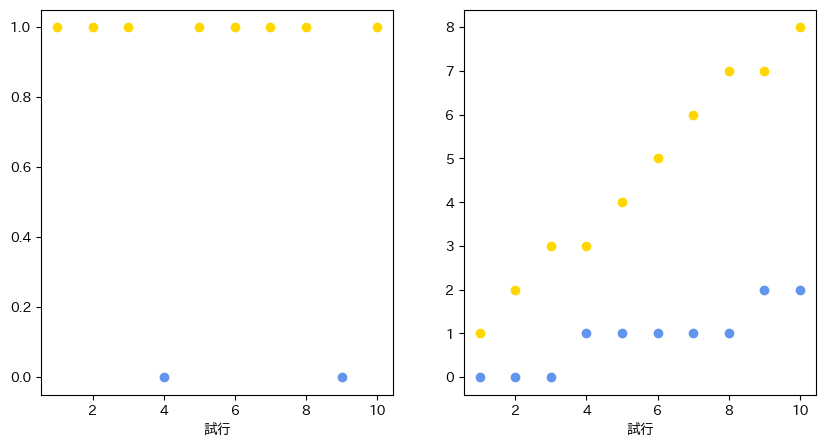

In [2]:
# ビーズの設定
beads = np.array([1,1,1,0,1,1,1,1,0,1])
# 左に各試行で出たビーズの色，右に累積数をプロット
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# 左図のプロット
for x, bead in zip(range(1, 11), beads):
    color = 'gold' if bead == 1 else 'cornflowerblue'
    axes[0].scatter(x, bead, color=color)
axes[0].set_xlabel('試行')
# 右図のプロット
axes[1].scatter(range(1, 11), np.cumsum(beads), marker='o', color='gold')
axes[1].scatter(range(1, 11), np.cumsum(1-beads), marker='o', color='cornflowerblue')
axes[1].set_xlabel('試行')

## パタメータ化信念更新モデル

- `pbum`関数を定義します。引数は`beads_dominant`，`w1`，`w2`をとります。`beads_dominant`は，関心のある瓶において割合が多く優勢なビーズの色が出たら1，もう一方の色が出たら0で並べたものです。`w1`事前信念のパラメータ，，`w2`は尤度比のパラメータです。

In [3]:
def pbum(beads_dominant, w1,w2):
    #優勢な色のビーズの確率
    q = 0.8
    # 信念の初期値
    b = 0.0
    # 瓶Aの確率を保存する場所
    p_A = []
    for bead in beads_dominant:
        # 信念の更新式 式(7)
        if bead == 1:
            b = w1 * b + w2 * np.log(q / (1 - q))
        else:
            b = w1 * b + w2 * np.log((1 - q) / q)
        # シグモイド関数で確率に変換
        p_A.append(expit(b))
    # データフレーム形式に変換して出力
    data = pd.DataFrame({'beads_dominant': beads_dominant, 'probA': p_A})
    return data

### パラメータ化信念更新モデルの動作確認

- `pbum`関数の動作確認のために，シミュレーションをします。信念更新モデルはオレンジ色でプロットします($\omega 1$ =1.0, $\omega 2$ = 1.0)。
- **左図**：$\omega 1$ を0.5にした時のパラメータ化信念更新モデルを緑色でプロットします。
- **右図**： $\omega 2$ を0.5にした時のパラメータ化信念更新モデルを緑色でプロットします。
- コードの右側に出ているw2_right,w1_leftを変更すると自由にパラメータを変えられます。

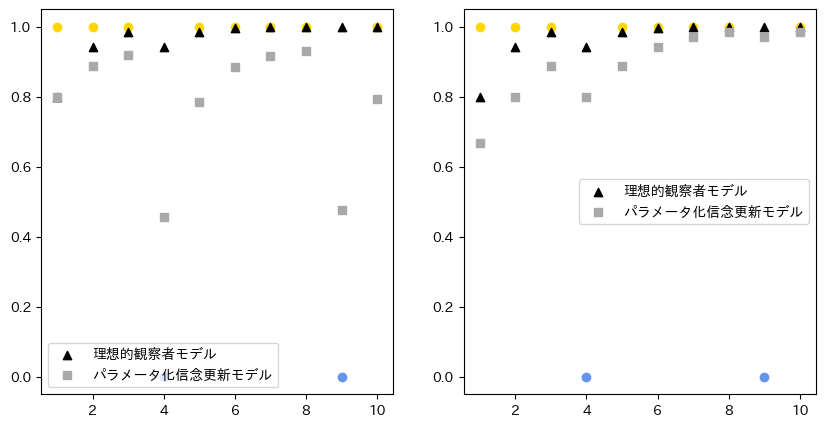

In [4]:
#複数の図を一枚にプロットします
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
#各wにおける瓶Aの推定された確率を計算します
p_A_1 = pbum(beads, w1 = 1.0, w2 = 1.0)
w_left = 0.5 #@param
p_A_2 = pbum(beads, w1 = w_left, w2 =1.0)
# w = w_left の時の推定された確率のプロット
for x, bead in zip(range(1, 11), beads):
    color = 'gold' if bead == 1 else 'cornflowerblue'
    axes[0].scatter(x, bead, color=color)
axes[0].scatter(range(1, 11), p_A_1['probA'], marker='^', color='black', label='理想的観察者モデル')
axes[0].scatter(range(1, 11),p_A_2['probA'], marker='s', color='darkgray', label='パラメータ化信念更新モデル')
axes[0].legend()
#各wにおける瓶Aの推定された確率を計算します
w_right = 0.5 #@param
p_A_3 = pbum(beads,w1 = 1.0, w2 = w_right)
# w = w_rightの時の推定された確率のプロット
for x, bead in zip(range(1, 11), beads):
    color = 'gold' if bead == 1 else 'cornflowerblue'
    axes[1].scatter(x, bead, color=color)
axes[1].scatter(range(1, 11), p_A_1['probA'], marker='^', color='black', label='理想的観察者モデル')
axes[1].scatter(range(1, 11),p_A_3['probA'], marker='s', color='darkgray', label='パラメータ化信念更新モデル')
axes[1].legend()

## パラメータ推定

### パラメータを評価する基準を設定

- パラメータを評価する基準ｎとしてRMSEを用います。
- RMSEを計算する`calc_rmse`関数を用意します。引数は，`params`と`data`をとります。`params`にパラメータ（w1,w2），`data`には参加者の推定した確率の反応データをいれます。


In [5]:
def calc_rmse(params, data):
    #パラメータ
    w1, w2 = params
    #モデルによる推定値を計算
    estimated = pbum(data['beads_dominant'], w1, w2)
    #推定値と参加者の反応の誤差の二乗を平均し平方根をとる
    rmse = np.sqrt(np.mean((np.array(estimated['probA']) - data['probA']) ** 2))
    return rmse

- `calc_rmse`関数の動作確認をしてみましょう。
- $\omega_{1}$ と　$\omega_{2}$が1.0の時のデータを生成し（真値），そのデータに対して， $\omega_{1}$ が0.5や0.8にしたときのRMSEを計算してみましょう。

In [6]:
# データ生成
data = pbum(beads, w1 = 1.0, w2 = 1.0)
w1 = 0.5 #@param
w2 = 1.0
calc_rmse(params = [w1,w2], data = data)

0.2491358240120871

### パラメータ推定法の設定

- RMSEが最小になるパラメータを推定します。
- 強化学習ではRの`optim`関数を用いてパラメータ推定を行いましたが，PythonでもSciPyパッケージの`minimize`関数が使えます（ 準Newton法のL-BFGS-Bアルゴリズム）
- 初期値によって推定値のばらつきが生じることがあるので10回推定して，もっともRMSEの小さなパラメータを採用します。そのための，`find_best_minimum`関数を設定します。

In [7]:
def find_best_minimum(objective_fun, data, bounds, num_iterations=10):
    #目的関数が最小値の推定値の保存場所
    best_result = None
    minimum_obj_fun = float('inf')
    for i in range(num_iterations):
        # boundsで定めた範囲内で初期値の準備
        initial_guess = [np.random.uniform(bound[0], bound[1]) for bound in bounds]
        # １つの推定でエラーが出ても実行できるようにtry-except文を使用
        try:
            # 最小値の探索
            result = minimize(objective_fun, initial_guess, bounds=bounds, args=(data,), method="L-BFGS-B")
            # 推定結果の一時保存
            result_tmp = result.fun
            # 最小の対数尤度に更新
            if result_tmp < minimum_obj_fun:
                minimum_obj_fun = result_tmp
                best_result = result
        except Exception as e:
            print(f"Error in iteration {i+1}: {str(e)}")
            continue
    return best_result

推定をしてみます。真の $\omega$ を1.98に設定してデータを生成します。そのデータから $\omega$ を推定します。ほぼ一致しました。他の値でも試してみましょう。

In [8]:
# 真値の設定とデータ生成
true_w1 = 0.8  #@param
true_w2 = 0.5  #@param
data = pbum(beads, w1 = true_w1, w2 = true_w2)
# パラメータ推定
best_result = find_best_minimum(calc_rmse, data, [(0,1),(0,1)])
print("w1:", best_result.x[0])
print("w2:", best_result.x[1])

w1: 0.8000000001946388
w2: 0.4999999998314923


###パラメータリカバリーによる検証

- (1)`pbum`関数で真値からのデータ生成，(2)`find_best_minimum`関数でパラメータ推定,(3)`w_estimated.append`で推定した値の保存を繰り返します。

In [9]:
# サンプルサイズ，乱数のシード，真値の設定（0以下にならないように設定）
sample_size = 20    #@param
np.random.seed(123)
w1_true = np.random.uniform(0, 1, sample_size)
w2_true = np.random.uniform(0, 1, sample_size)
# 真値からデータ生成，パラメータ推定，保存を繰り返す
w1_estimated = []
w2_estimated = []
for j in range(sample_size):
    sim_data = pbum(beads, w1 = w1_true[j], w2 = w2_true[j])
    best_result = find_best_minimum(calc_rmse, sim_data, [(0,1),(0,1)])
    w1_estimated.append(best_result.x[0])
    w2_estimated.append(best_result.x[1])

パラメータリカバリーについて散布図を書くのと相関係数を算出して確認します。対角線上に並んでおり，パラメータリカバリーできているといえます。

Text(0, 0.5, '$\\omega_{2}$の推定値')

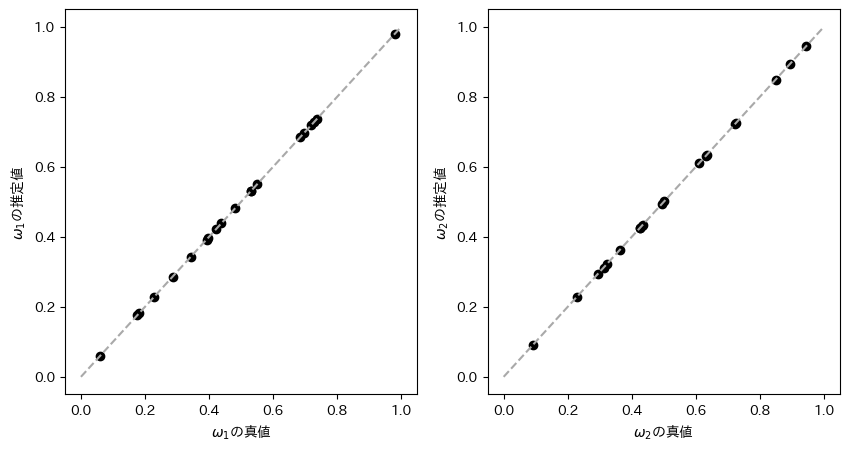

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot([0.0, 1.0], [0.0, 1.0], linestyle='--', color='darkgray')
axes[0].scatter(w1_true, w1_estimated, color='black')
axes[0].set_xlabel('$\omega_{1}$の真値')
axes[0].set_ylabel('$\omega_{1}$の推定値')
axes[1].plot([0.0, 1.0], [0.0, 1.0], linestyle='--', color='darkgray')
axes[1].scatter(w2_true, w2_estimated, color='black')
axes[1].set_xlabel('$\omega_{2}$の真値')
axes[1].set_ylabel('$\omega_{2}$の推定値')

# 3.カルマンフィルターモデル


## 使用するパッケージのインポート

In [11]:
# プロット用
import matplotlib.pyplot as plt
# matplotlibの日本語対応化用
!pip install japanize-matplotlib
import japanize_matplotlib
# 主に行列などの計算用
import numpy as np
# データフレームの作成用
import pandas as pd
# 乱数のシードの設定
np.random.seed(123)

## ポイントの出るスロットマシン課題

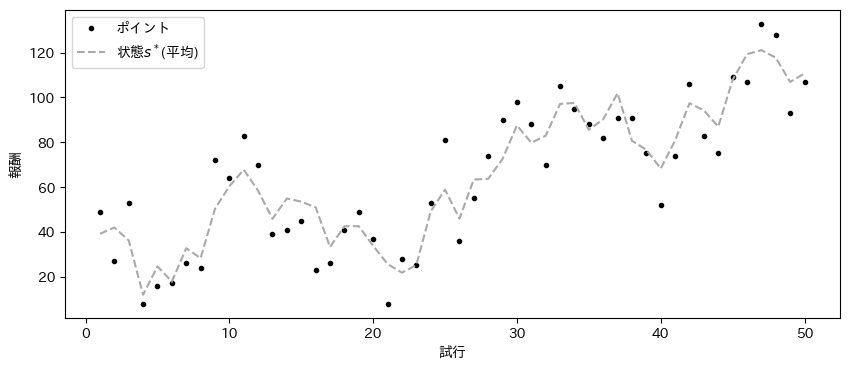

In [12]:
# 設定
trials = 50
true_mu, points = [None] * trials, [None] * trials
mu, sigma_d, sigma_o = 50, 10, 10
# ガウシアンランダムウォーク
for t in range(trials):
    mu = mu + np.random.normal(0, sigma_d, 1)[0] #式8
    true_mu[t] = mu
    points[t] = round(np.random.normal(mu, sigma_o, 1)[0]) #式9
# データフレーム形式に変換
input_data = pd.DataFrame({'trial_no': range(1, trials+1),
                           'point': points,'true_mu': true_mu})
# プロット
plt.figure(figsize=(10, 4))
plt.scatter(input_data['trial_no'],input_data['point'], marker='.', color='black',label='ポイント')
plt.plot(input_data['trial_no'],input_data['true_mu'], linestyle='--', color='darkgray', label='状態$s^*$(平均)')
plt.xlabel('試行')
plt.ylabel('報酬')
plt.legend()

## カルマンフィルターモデル

In [13]:
def kf(point, sigma_o, sigma_d):
    trials = len(point)
    # パラメータの保存場所
    trial_no, mu, sigma2, kg, mu_post = [[0] * trials for _ in range(5)]
    # パラメータの設定(初期値)
    mu[0] = 0
    sigma2[0] = 5
    # ベイズ更新
    for t in range(trials):
        # カルマンゲイン
        kg[t] = sigma2[t] / (sigma2[t] + sigma_o ** 2)
        # 現在の状態sの事後分布の平均（プロット用）
        mu_post[t] = mu[t] + kg[t] * (point[t] - mu[t])
        if t < trials-1:
            # 次の時点の状態sの事前分布の平均
            mu[t+1] = mu[t] + kg[t] * (point[t] - mu[t])
            # 次の時点の状態sの事前分布の分散
            sigma2[t+1] = (1 - kg[t]) * sigma2[t] + sigma_d ** 2
        # 試行番号
        trial_no[t] = t + 1
    # データフレーム形式に変換して出力
    estimates = pd.DataFrame({'trial_no':trial_no,'mu':np.array(mu),
                'mu_post':mu_post, 'sigma':np.sqrt(np.array(sigma2)),'kg':kg})
    return estimates

図１０

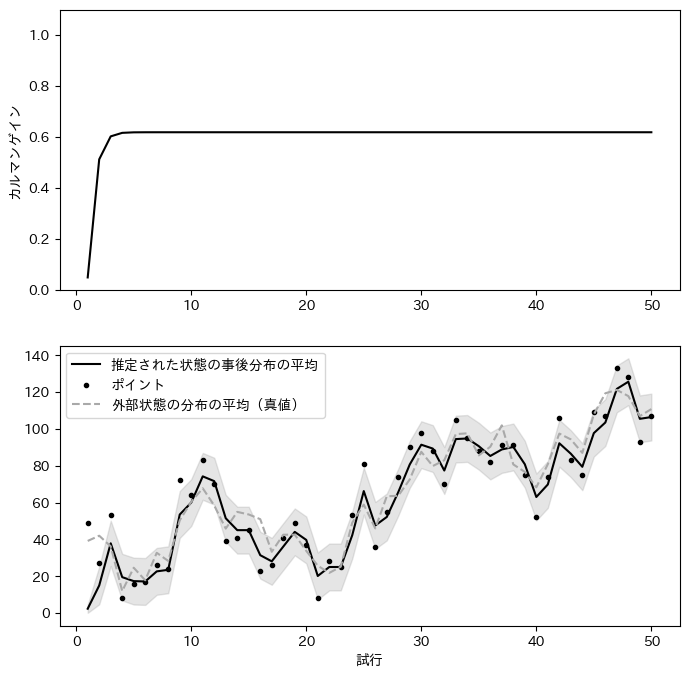

In [14]:
# パラメータの設定
sigma_o = 10  #@param
sigma_d = 10  #@param
# カルマンフィルターによる推定
estimates = kf(input_data['point'],sigma_o = sigma_o,sigma_d = sigma_d)
# プロット
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# 上段にカルマンゲインをプロット
axes[0].plot(estimates['trial_no'], estimates['kg'], linestyle='-', color='black')
axes[0].set_ylabel('カルマンゲイン')
axes[0].set_ylim(0, 1.1)
# 下段に状態の平均をプロット
axes[1].plot(estimates['trial_no'], estimates['mu_post'], linestyle='-', color='black', label='推定された状態の事後分布の平均')
axes[1].fill_between(estimates['trial_no'], estimates["mu_post"] - estimates["sigma"], estimates["mu_post"] + estimates["sigma"], color='gray', alpha=0.2)
axes[1].scatter(input_data['trial_no'], input_data['point'], marker='.', color='black', label='ポイント')
axes[1].plot(input_data['trial_no'], input_data['true_mu'], linestyle='--', color='darkgray', label='外部状態の分布の平均（真値）')
axes[1].set_xlabel('試行')
axes[1].legend()

図１１

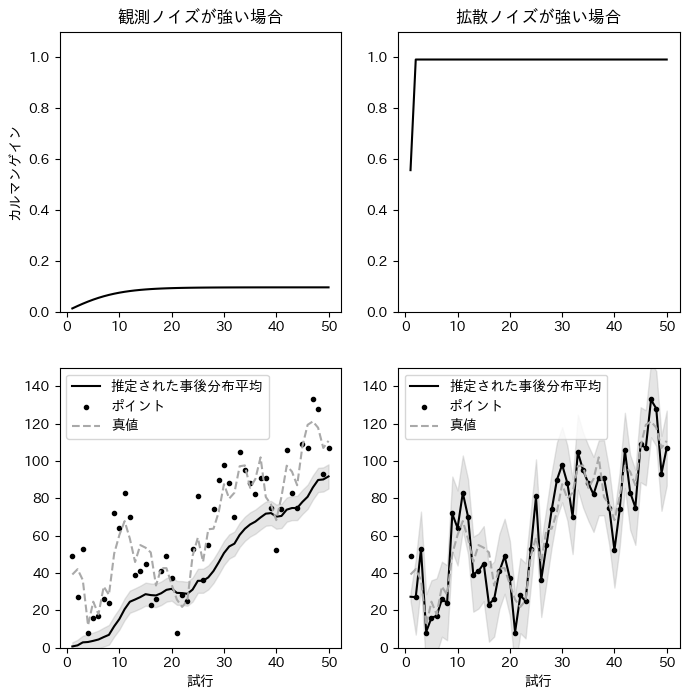

In [15]:
# カルマンフィルターによる推定
estimates1 = kf(input_data['point'], sigma_o = 20, sigma_d = 2)
estimates2 = kf(input_data['point'], sigma_o = 2, sigma_d = 20)
# プロット
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
# 左上のプロット
axes[0,0].plot(estimates1['trial_no'], estimates1['kg'], linestyle='-', color='black')
axes[0,0].set_ylabel('カルマンゲイン')
axes[0,0].set_title('観測ノイズが強い場合')
axes[0,0].set_ylim(0, 1.1)
# 左下のプロット
axes[1,0].plot(estimates1['trial_no'], estimates1['mu_post'], linestyle='-', color='black', label='推定された事後分布平均')
axes[1,0].fill_between(estimates1['trial_no'], estimates1["mu_post"] - estimates1["sigma"], estimates1["mu_post"] + estimates1["sigma"], color='gray', alpha=0.2)
axes[1,0].scatter(input_data['trial_no'], input_data['point'], marker='.', color='black', label='ポイント')
axes[1,0].plot(input_data['trial_no'], input_data['true_mu'], linestyle='--', color='darkgray', label='真値')
axes[1,0].set_xlabel('試行')
axes[1,0].set_ylim(0, 150)
axes[1,0].legend()
# 右上のプロット
axes[0,1].plot(estimates2['trial_no'], estimates2['kg'], linestyle='-', color='black')
axes[0,1].set_ylim(0, 1.1)
axes[0,1].set_title('拡散ノイズが強い場合')
# 右下のプロット
axes[1,1].plot(estimates2['trial_no'], estimates2['mu_post'], linestyle='-', color='black', label='推定された事後分布平均')
axes[1,1].fill_between(estimates2['trial_no'], estimates2["mu_post"] - estimates2["sigma"], estimates2["mu_post"] + estimates2["sigma"], color='gray', alpha=0.2)
axes[1,1].scatter(input_data['trial_no'], input_data['point'], marker='.', color='black', label='ポイント')
axes[1,1].plot(input_data['trial_no'], input_data['true_mu'], linestyle='--', color='darkgray', label='真値')
axes[1,1].set_xlabel('試行')
axes[1,1].set_ylim(0, 150)
axes[1,1].legend()

# 4.階層ガウシアンフィルター

In [16]:
# プロット用
import matplotlib.pyplot as plt
# matplotlibの日本語対応化用
!pip install japanize-matplotlib
import japanize_matplotlib
# 主に行列などの計算用
import numpy as np
# データフレームの作成用
import pandas as pd

## 変動性のある確率的逆転学習課題

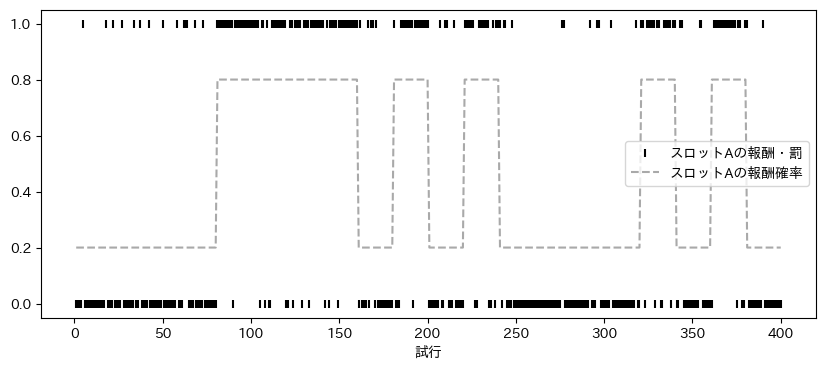

In [17]:
# 試行のブロックと確率の設定と保存場所
trial_block = [80, 80, 20,20,20,20,80,20,20,20,20]
p_A = [0.2, 0.8, 0.2, 0.8,0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2]
reward_A, prob_A = [],[]
# np.random.choiceで報酬(1)と罰(0)を生成する
for t in range(len(trial_block)):
    reward_A.extend(np.random.choice([1, 0], trial_block[t], p=[p_A[t], 1-p_A[t]]))
    prob_A.extend(np.repeat(p_A[t], trial_block[t]))
# データフレーム形式に変換
input_data = pd.DataFrame({'trial_no': range(1, 401),'reward_A': reward_A,'prob_A': prob_A})
# プロット
plt.figure(figsize=(10, 4))
plt.scatter(input_data['trial_no'],input_data['reward_A'], marker='|', color='black',label='スロットAの報酬・罰')
plt.plot(input_data['trial_no'],input_data['prob_A'], linestyle='--', color='darkgray', label='スロットAの報酬確率')
plt.xlabel('試行')
plt.legend()

## HGFで使うpyhgfパッケージと関連パッケージのインポート

In [18]:
# HGF用パッケージのインストール
!pip install pyhgf==0.1.2
from pyhgf.distribution import HGFDistribution, hgf_logp
from pyhgf.model import HGF
from pyhgf.response import binary_softmax_inverse_temperature
# MCMC関連用
import arviz as az
import pymc as pm
# 主に行列などの計算用
import jax.numpy as jnp
np.set_printoptions(suppress=True)
# 乱数のシード値の設定
np.random.seed(123)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 2.1 MB/s eta 0:00:00


In [19]:
#pyhgfのバージョン確認
!pip show pyhgf

Name: pyhgf
Version: 0.1.2
Summary: The generalized, nodalized HGF for predictive coding.
Home-page: 
Author: ILAB
Author-email: nicolas.legrand@cas.au.dk
License: GPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: arviz, jax, jaxlib, matplotlib, numpy, packaging, pymc, seaborn, setuptools
Required-by: 


### エージェントの準備

In [20]:
agent = HGF(
    n_levels=3,
    model_type="binary",
    initial_mean={"1": 0.0, "2": 0.0, "3": 0.0},
    initial_precision={"1": 0.0, "2": 1.0, "3": 1.0},
)

In [21]:
agent.attributes[2]["tonic_volatility"] = -3.0
agent.attributes[3]["tonic_volatility"] = 1.0
agent.input_data(input_data = np.array(input_data['reward_A']))

- 入力を与えたタイミングで状態sについての各種更新がなされます。以下のようにpandas形式見ることもできます。

In [22]:
agent.to_pandas().head()

,time_steps,time,observation_input_0,x_1_mean,x_1_precision,x_1_expected_mean,x_1_expected_precision,x_2_mean,x_2_precision,x_2_expected_mean,...,x_3_mean,x_3_precision,x_3_expected_mean,x_3_expected_precision,observation_input_0_surprise,observation_input_0_expected_precision,x_1_surprise,x_2_surprise,x_3_surprise,total_surprise
0,1.0,1.0,0.0,0.0,inf,0.500000,0.250000,-0.415775,1.202574,0.000000,...,-0.003811,0.270994,0.000000,0.268941,0.693147,inf,1.643336,1.025567,1.575571,4.937622
1,1.0,2.0,0.0,0.0,inf,0.397528,0.239500,-0.705016,1.374384,-0.415775,...,-0.018116,0.159610,-0.003811,0.156045,0.506715,inf,1.652464,0.903146,1.847760,4.910084
2,1.0,3.0,0.0,0.0,inf,0.330701,0.221338,-0.924142,1.509181,-0.705016,...,-0.042106,0.115631,-0.018116,0.111315,0.401525,inf,1.685074,0.823373,2.016668,4.926640
3,1.0,4.0,0.0,0.0,inf,0.284115,0.203394,-1.100484,1.611160,-0.924142,...,-0.073600,0.092634,-0.042106,0.087978,0.334235,inf,1.723454,0.769825,2.134316,4.961830
4,1.0,5.0,1.0,1.0,inf,0.249649,0.187324,-0.655632,1.686743,-1.100484,...,0.013406,0.070860,-0.073600,0.074001,1.387698,inf,1.809129,0.864762,2.221060,6.282650


### 分布の平均値の軌跡を確認

- 各階層の状態の分布の平均について，時間経過に伴う軌跡をプロットできます。

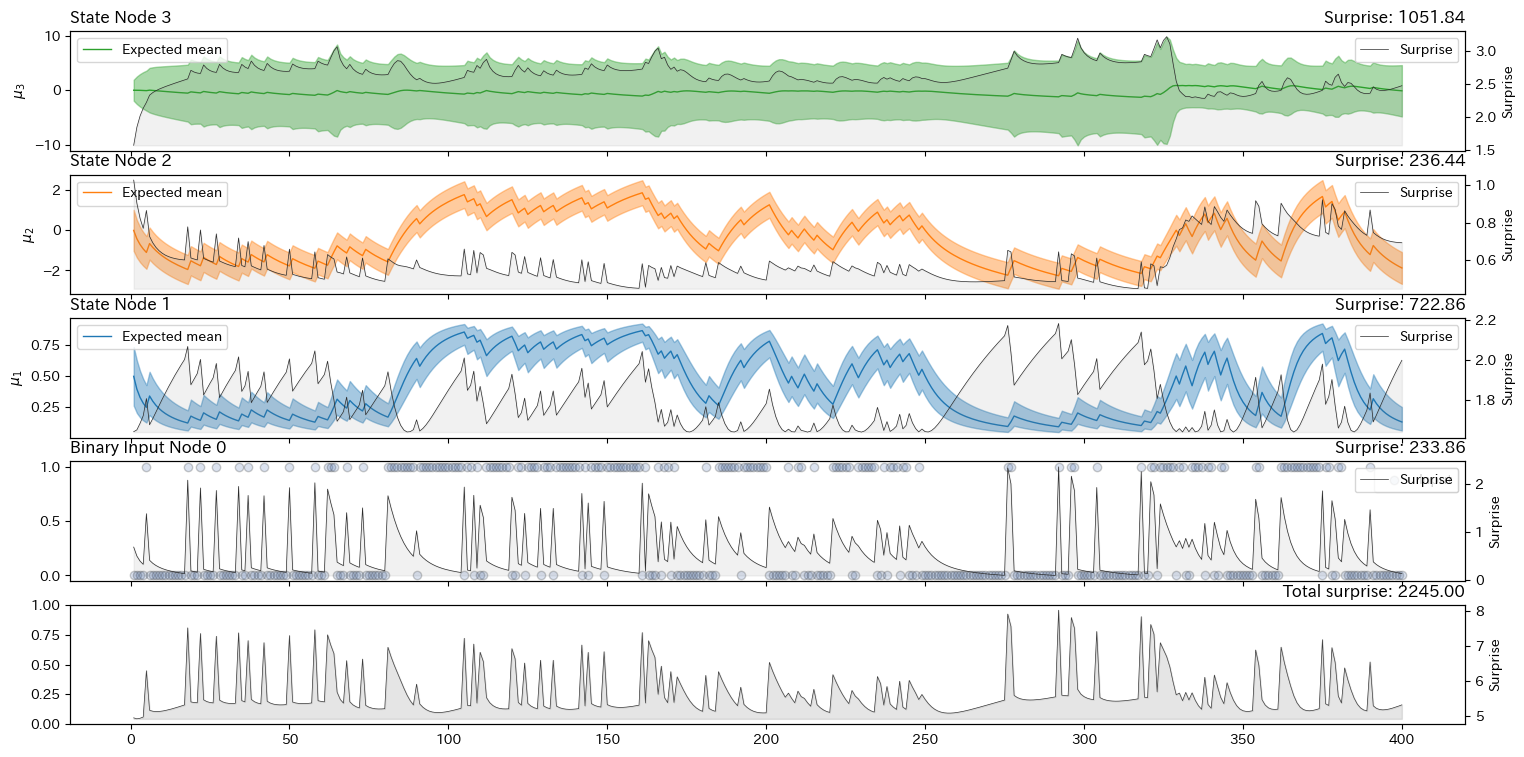

In [23]:
agent.plot_trajectories();

- $S3$($x_{3}$)の変動が見えにくいので別にプロットをしてみます。

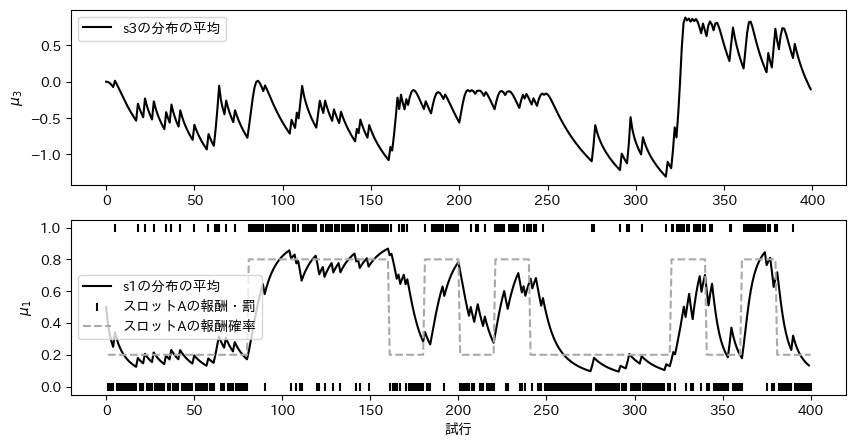

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(agent.node_trajectories[3]["expected_mean"], linestyle="-", color='black', label="s3の分布の平均")
axes[0].set_ylabel('$\mu_{3}$')
axes[0].legend()
axes[1].plot(agent.node_trajectories[1]["expected_mean"], linestyle="-", color='black', label="s1の分布の平均",)
axes[1].scatter(input_data['trial_no'],input_data['reward_A'], marker='|', color='black',label='スロットAの報酬・罰')
axes[1].plot(input_data['trial_no'],input_data['prob_A'], linestyle='--', color='darkgray', label='スロットAの報酬確率')
axes[1].set_ylabel('$\mu_{1}$')
axes[1].set_xlabel('試行')
axes[1].legend()

シグモイド関数（逆温度含む）

In [25]:
def sigmoid(x, beta):
    return (x**beta) / (x**beta + (1-x)**beta)

反応を生成してプロットします。

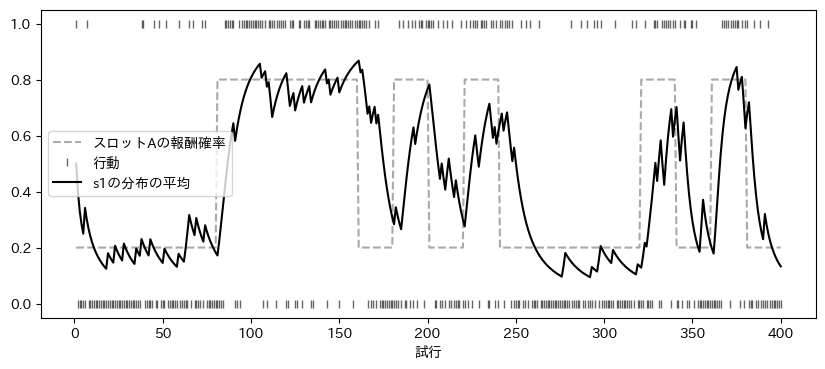

In [26]:
p = sigmoid(x=agent.node_trajectories[1]["expected_mean"], beta=1.0)
response_agent = np.random.binomial(p=p, n=1)

plt.figure(figsize=(10, 4))
plt.plot(input_data['trial_no'], input_data['prob_A'], linestyle='--', color='darkgray', label='スロットAの報酬確率')
plt.plot(input_data['trial_no'],response_agent, linestyle='none', marker='|', color="black", label="行動", alpha=0.6)
plt.plot(input_data['trial_no'],agent.node_trajectories[1]["expected_mean"], linestyle="-", color="black", label="s1の分布の平均")
plt.xlabel('試行')
plt.legend()

### シミュレーションデータの生成（20名）

In [27]:
# サンプルサイズの設定
sample_size = 20    #@param
# パラメータの真値を設定
inverse_temperatures = np.random.uniform(0.1, 5.0, sample_size)
volatilities2 = np.random.uniform(-6.0, -1.0, sample_size)
volatilities3 = np.random.uniform(-6.0, -1.0, sample_size)
# 行動データの生成
responses = []
for i in range(sample_size):
    # パラメータの設定
    agent.attributes[2]["tonic_volatility"] = volatilities2[i]
    agent.attributes[3]["tonic_volatility"] = volatilities3[i]
    agent.input_data(input_data = np.array(input_data['reward_A']))
    # 選択確率の計算
    p = sigmoid(x=agent.node_trajectories[1]["expected_mean"],
                beta=inverse_temperatures[i])
    # ベルヌーイ分布で生成した反応の保存
    responses.append(np.random.binomial(p=p, n=1))

生成した行動の確認（２名分）

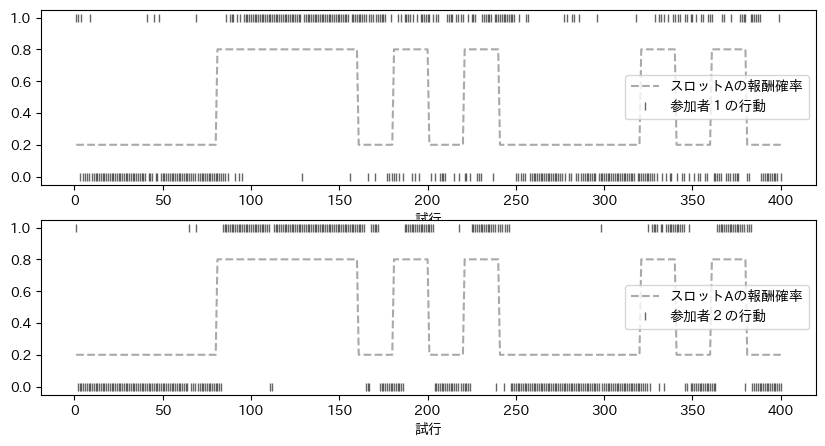

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(input_data['trial_no'], input_data['prob_A'], linestyle='--', color='darkgray', label='スロットAの報酬確率')
axes[0].plot(input_data['trial_no'],responses[1], linestyle='none', marker='|', color="black", label="参加者１の行動", alpha=0.6)
axes[0].set_xlabel('試行')
axes[0].legend()
axes[1].plot(input_data['trial_no'], input_data['prob_A'], linestyle='--', color='darkgray', label='スロットAの報酬確率')
axes[1].plot(input_data['trial_no'],responses[2], linestyle='none', marker='|', color="black", label="参加者２の行動", alpha=0.6)
axes[1].set_xlabel('試行')
axes[1].legend()

### HGFでのパラメータ推定

- 今度は，シミュレーションデータを使って，パラメータ推定を行います。知覚モデル（３階層，バイナリー）とデータと反応モデルを設定します。

In [29]:
hgf_L3 = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=[np.array(input_data['reward_A'])] * sample_size,
    response_function=binary_softmax_inverse_temperature,
    response_function_inputs=responses,
)

- 事前分布を指定して，PyMCで推定できるように準備をします。

In [30]:
with pm.Model() as L3_binary_hgf:
    # 事前分布の準備(w2)
    volatility2 = pm.Normal.dist(-3.0, 1, shape=sample_size)
    censored_volatility2 = pm.Censored("censored_volatility2", volatility2, lower=-8, upper=2)
    # 事前分布の準備(w3)
    volatility3 = pm.Normal.dist(-3.0, 1, shape=sample_size)
    censored_volatility3 = pm.Censored("censored_volatility3", volatility3, lower=-8, upper=2)
    # 事前分布の準備(beta)
    inverse_temperature = pm.Uniform("inverse_temperature", .1, 20, shape=sample_size, initval=np.ones(sample_size))
    # 尤度と事前分布の設定
    pm.Potential("hgf_loglike",
        hgf_L3(tonic_volatility_2=censored_volatility2,
            tonic_volatility_3=censored_volatility3,
            response_function_parameters=inverse_temperature))

- MCMCを用いてパラメータ推定をします。
２チェーンで6分,4チェーンで17-19分

In [31]:
with L3_binary_hgf:
    L3_hgf_idata = pm.sample(chains=4, cores=1)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
ERROR:pymc.stats.convergence:There were 482 divergences after tuning. Increase `target_accept` or reparameterize.


In [32]:
pm.summary(L3_hgf_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
censored_volatility2[0],-3.371,0.256,-3.877,-2.926,0.004,0.003,4067.0,2828.0,1.0
censored_volatility2[1],-4.222,0.287,-4.754,-3.688,0.004,0.003,4495.0,3073.0,1.0
censored_volatility2[2],-1.424,0.207,-1.780,-1.005,0.003,0.002,3842.0,2701.0,1.0
censored_volatility2[3],-1.739,0.296,-2.310,-1.197,0.005,0.003,3946.0,2652.0,1.0
censored_volatility2[4],-4.213,0.177,-4.540,-3.880,0.003,0.002,4402.0,2548.0,1.0
censored_volatility2[5],-2.537,0.759,-4.054,-1.181,0.011,0.009,4595.0,2328.0,1.0
censored_volatility2[6],-1.742,0.215,-2.133,-1.333,0.003,0.002,4288.0,2581.0,1.0
censored_volatility2[7],-3.847,0.244,-4.312,-3.400,0.004,0.003,4436.0,3425.0,1.0
censored_volatility2[8],-2.652,0.265,-3.158,-2.184,0.004,0.003,4028.0,2351.0,1.0
censored_volatility2[9],-2.793,0.842,-4.403,-1.284,0.012,0.009,4908.0,3130.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'censored_volatility2'}>,
        <Axes: title={'center': 'censored_volatility2'}>],
       [<Axes: title={'center': 'censored_volatility3'}>,
        <Axes: title={'center': 'censored_volatility3'}>],
       [<Axes: title={'center': 'inverse_temperature'}>,
        <Axes: title={'center': 'inverse_temperature'}>]], dtype=object)

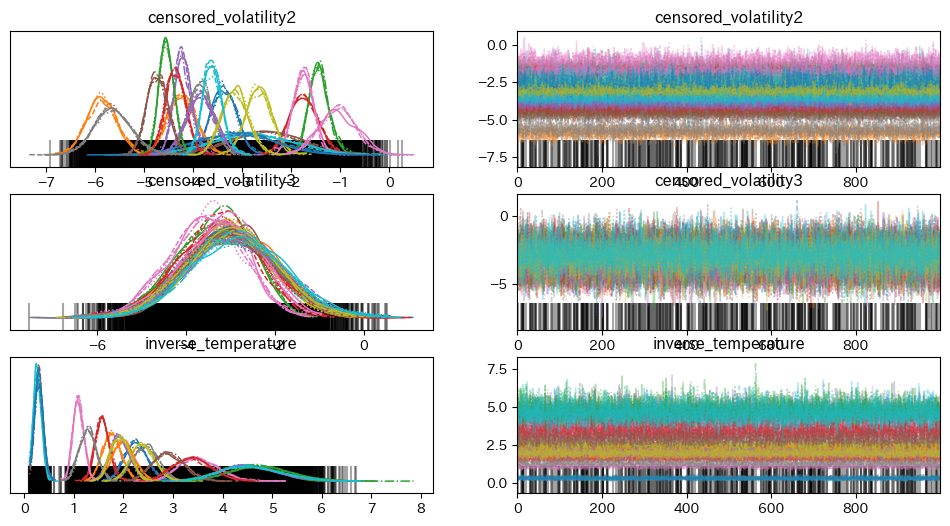

In [33]:
pm.plot_trace(L3_hgf_idata,compact=True)

- パラメータリカバリーのチェック

Text(0.5, 1.0, '逆温度')

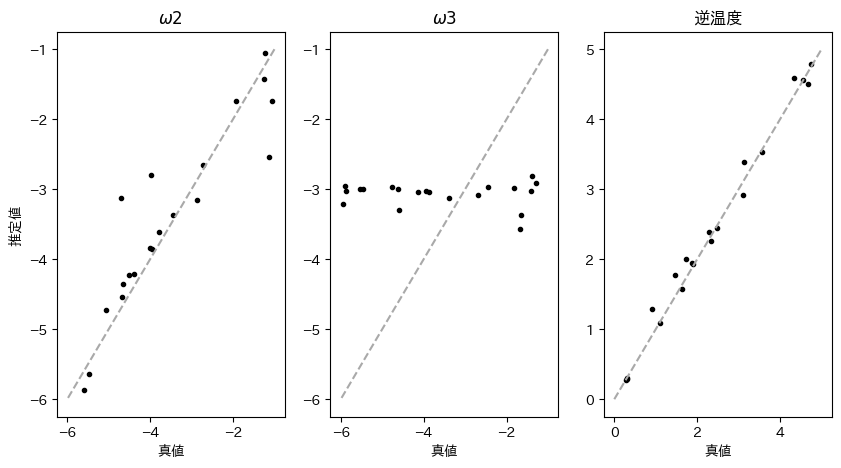

In [34]:
# 推定したパラメータの抽出
w2 = az.summary(L3_hgf_idata, var_names="censored_volatility2")["mean"].tolist()
w3 = az.summary(L3_hgf_idata, var_names="censored_volatility3")["mean"].tolist()
beta = az.summary(L3_hgf_idata, var_names="inverse_temperature")["mean"].tolist()
# パラメータリカバリの確認
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].scatter(volatilities2, w2, marker='.', color='black')
axes[0].plot([-1.0, -6.0], [-1.0, -6.0], linestyle='--', color='darkgray')
axes[0].set_xlabel("真値")
axes[0].set_ylabel("推定値")
axes[0].set_title('$\omega 2$')
axes[1].scatter(volatilities3, w3, marker='.', color='black')
axes[1].plot([-1.0, -6.0], [-1.0, -6.0], linestyle='--', color='darkgray')
axes[1].set_xlabel("真値")
axes[1].set_title('$\omega 3$')
axes[2].scatter(inverse_temperatures, beta, marker='.', color='black')
axes[2].plot([0.0, 5.0], [0.0, 5.0], linestyle='--', color='darkgray')
axes[2].set_xlabel("真値")
axes[2].set_title('逆温度')


# (5)能動的推論



## pymdpで使うパッケージのインストールとインポート

In [35]:
# 能動的推論のパッケージのインストール
!pip install inferactively-pymdp
# プロット用
import matplotlib.pyplot as plt
# matplotlibの日本語対応化
!pip install japanize-matplotlib
import japanize_matplotlib
# 主に行列などの計算用
import numpy as np
# 能動的推論用
import pymdp
from pymdp import utils
from pymdp.maths import softmax
from pymdp.agent import Agent

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00
  Attempting uninstall: Pygment

In [36]:
# pymdpのバージョン確認
!pip show inferactively-pymdp

Name: inferactively-pymdp
Version: 0.0.7.1
Summary: A Python package for solving Markov Decision Processes with Active Inference
Home-page: https://github.com/infer-actively/pymdp
Author: infer-actively
Author-email: conor.heins@gmail.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: attrs, autograd, cycler, iniconfig, kiwisolver, matplotlib, myst-nb, nose, numpy, openpyxl, packaging, pandas, Pillow, pluggy, py, pyparsing, pytest, python-dateutil, pytz, scipy, seaborn, six, sphinx-rtd-theme, toml, typing-extensions, xlsxwriter
Required-by: 


## 認識的価値を扱う２椀バンディット課題

認識的価値を扱う２腕バンディット課題では，参加者に２つのスロットマシーンのうちどちらかが高い確率で当たるが，どちらか分からないので，探索行動をして選択するように教示されます。また，各試行で有利なスロットマシーンがいつも同じとは限らないことも伝えます。スロットマシーンが当たると４ドルを獲得できますが，もしどちらか分からない場合はヒントを得るボタンを押すことができます。もしヒントを選んだ場合は，正答しても得るのは２ドルです。このように，ヒントをいれることで，実利的価値だけでなく認識的価値も扱うことができるようになっています。早速，この課題に関する能動的推論モデルの設定をしてみましょう。

## **D**（初期状態の事前信念）の設定

　まず，このモデルにおける状態sの値や数について整理をします。まず，スロットマシーンAが良いブロックとスロットマシーンBが良いブロックの２つの値があります。次に，選択肢として，開始状態(Start)，ヒント選択(Hint)，A選択(A)，B選択(B)の４つの値があります。それぞれの状態の値の数と因子の数を変数に保存します。

In [37]:
# 文脈や選択肢の種類，状態や因子の数の設定
context_names = ['A-Better', 'B-Better']
choice_names = ['Start', 'Hint', 'A', 'B']
num_states = [len(context_names), len(choice_names)]
num_factors = len(num_states)
num_factors

2

上記の因子数をもとに，初期状態に関する事前信念を設定します。utils.obj_array()を使って，配列オブジェクトを用意します。２つの状態からなる文脈については，AとBのどちらが得かわからないので，事前分布として等確率を割り振りました。また，選択については，最初は開始状態なので，開始状態にだけ1.0が割り振られるようにしています。

In [38]:
# D(初期状態の事前信念)の準備
D = utils.obj_array(num_factors)
# AとBのどっちが良いか分からないので等確率にする
D_context = np.array([0.5,0.5])
D[0] = D_context
# 初期状態では"Start"状態であるのは確実なので，Startに１を割り振る
D_choice = np.zeros(len(choice_names))
D_choice[choice_names.index("Start")] = 1.0
D[1] = D_choice
# Dの確認
D[0]

array([0.5, 0.5])

## **A**(尤度)の設定

尤度の設定をするため，観測（ヒント，報酬，選択肢）について整理をします。観測は３つあるので，尤度として３次元の配列を用意します。

まず，ヒントの尤度を設定します。尤度は，状態sがある値に定まった際に，観測oがある値になる確率です。このような関係性をPyMPDでは3次元のテンソルを用いて記述します。例えば，ヒントの尤度の場合には，観測されるヒントの値は，文脈と選択肢によって定まります。この場合には，具体的なテンソルの形状としては，状態（文脈ならびに選択肢）が3次元テンソルの2次元目の値と3次元目の値を取った際に，観測（ヒント）が1次元目の値となる確率を，3次元テンソルに保存します。実装ではif文を用いて選択ごとにヒントの観測確率を設定します。



In [39]:
# 可能性のある観測の種類の設定
hint_obs_names = ['Null', 'Hint-A', 'Hint-B']
reward_obs_names = ['Null', 'Loss', 'Reward']
choice_obs_names = ['Start', 'Hint', 'A', 'B']
num_obs = [len(hint_obs_names), len(reward_obs_names), len(choice_obs_names)]
num_modalities = len(num_obs)
# A配列の準備
A = utils.obj_array( num_modalities )

まず，ヒントの尤度を設定します。尤度は，状態sがある値に定まった際に，観測oがある値になる確率です。このような関係性をPyMPDでは3次元のテンソルを用いて記述します。例えば，ヒントの尤度の場合には，観測されるヒントの値は，文脈と選択肢によって定まります。この場合には，具体的なテンソルの形状としては，状態（文脈ならびに選択肢）が3次元テンソルの2次元目の値と3次元目の値を取った際に，観測（ヒント）が1次元目の値となる確率を，3次元テンソルに保存します。実装ではif文を用いて選択ごとにヒントの観測確率を設定します。

In [40]:
# ヒントに関する尤度(A[0])の設定（ヒントの観測・文脈・選択の３次元テンソル）
A_hint = np.zeros( (len(hint_obs_names), len(context_names), len(choice_names)) )
for choice_id, choice_name in enumerate(choice_names):
    if choice_name == 'Start':
        # Start状態なら，各文脈へのno-Hintの確率が1.0
        A_hint[0,:,choice_id] = 1.0
    elif choice_name == 'Hint':
        # ヒントを選択したなら，各文脈へのヒントの確率が1.0
        # ヒントA
        A_hint[1,:,choice_id] = np.array([1.0,0.0])
        # ヒントB
        A_hint[2,:,choice_id] = np.array([0.0,1.0])
        # AもしくはBを選択したなら，各文脈へのno-Hintの確率が1.0
    elif choice_name == 'A':
        A_hint[0,:,choice_id] = 1.0
    elif choice_name == 'B':
        A_hint[0,:,choice_id] = 1.0

A[0] = A_hint
# A[0]の確認（ヒントの選択時）
A[0][:,:,1]

array([[0., 0.],
       [1., 0.],
       [0., 1.]])

次に，報酬の尤度を設定します。設定にあたり，報酬の観測・文脈・選択の３次元テンソルで準備をします。選択ごとに報酬の観測確率を設定します。

In [41]:
# 報酬に関する尤度(A[1])の設定（報酬の観測・文脈・選択の３次元テンソル）
A_reward = np.zeros((len(reward_obs_names), len(context_names), len(choice_names)))
# 報酬の確率
p_reward = 0.8
for choice_id, choice_name in enumerate(choice_names):
    # StartとHintの時は，各文脈で'None'の確率が1.0
    if choice_name == 'Start':
        A_reward[0,:,choice_id] = 1.0
    elif choice_name == 'Hint':
        A_reward[0,:,choice_id] = 1.0
    # AとBは選択に対して，各文脈に対して報酬の得られる確率を設定する
    elif choice_name == 'A':
        # Loss
        A_reward[1,:,choice_id] = np.array([1.0 - p_reward, p_reward])
        # Rerward
        A_reward[2,:,choice_id] = np.array([p_reward, 1.0 - p_reward])
    elif choice_name == 'B':
        # Loss
        A_reward[1, :, choice_id] = np.array([p_reward, 1.0 - p_reward])
        # Reward
        A_reward[2, :, choice_id] = np.array([1- p_reward, p_reward])

A[1] = A_reward
# A[1]の確認（A選択時）
A[1][:,:,2]

array([[0. , 0. ],
       [0.2, 0.8],
       [0.8, 0.2]])

最後に，選択の尤度を設定します。設定にあたり，選択の観測・文脈・選択の３次元テンソルで準備をします。選択と選択の観測は完全に一致するという設定で，確率を設定します。

In [42]:
# 選択に関する尤度(A[1])の設定（選択の観測・文脈・選択の３次元テンソル）
A_choice = np.zeros((len(choice_obs_names), len(context_names), len(choice_names)))
# 選択と選択の観測は一致するので，対応するセルに確率1.0を追加
for choice_id in range(len(choice_names)):
    A_choice[choice_id, :, choice_id] = 1.0
A[2] = A_choice
# A[2]の確認（B選択時）
A[2][:,:,3]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.]])

## **B**（遷移確率）の設定

文脈と行為，選択と行為に関する遷移行列を設定します。文脈については，文脈・文脈・文脈-行為の３次元テンソルを用意しますが，各試行内で文脈が変わることはないので，単位行列を使っています。

In [43]:
# 文脈と行動についての遷移行列についての設定
context_action_names = ['Do-nothing']
choice_action_names = ['Move-start', 'Get-hint', 'Choose-A', 'Choose-B']
num_controls = [len(context_action_names), len(choice_action_names)]
# B配列の準備（因子の数だけ用意する）
B = utils.obj_array(num_factors)
# 文脈の遷移確率（文脈・文脈・文脈-行為の３次元テンソル）
B_context = np.zeros( (len(context_names), len(context_names), len(context_action_names)) )
# 各試行内で文脈は変わらないので単位行列を用いる
B_context[:,:,0] = np.eye(len(context_names))
B[0] = B_context
# B[0]の確認
B[0][:,:,0]

array([[1., 0.],
       [0., 1.]])

選択については，選択・選択・選択-行為の３次元テンソルを用意しますが，各試行内で文脈が変わることはないので，単位行列を使っています。

In [44]:
# 選択の遷移確率（選択・選択・選択-行為の３次元テンソル）
B_choice = np.zeros( (len(choice_names), len(choice_names), len(choice_action_names)) )
# 各試行内で文脈は変わらないので単位行列を用いる
for choice_i in range(len(choice_names)):
    B_choice[choice_i, :, choice_i] = 1.0
B[1] = B_choice
# B[1]の確認(ヒント選択時)
B[1][:,:,1]

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## **C**（観測データの事前信念）の設定

選好を事前信念として設定します。ヒント，選択，Noneは0,Lossは-4,Rewardは2に設定します。

In [45]:
# C配列の準備
C = utils.obj_array_zeros(num_obs)
# 観測（ヒント，報酬，選択）の中でヒントと選択には選好はないので0
# Noneは0,Lossは-4, rewardは2
C_reward = np.zeros(len(reward_obs_names))
C_reward[1] = -4.0
C_reward[2] = 2.0
C[1] = C_reward
# C[1]の確認
C[1]

array([ 0., -4.,  2.])

## 能動的推論エージェントの準備

設定した尤度($\textbf{A}$)，遷移確率 ($\textbf{B}$)，観測データの事前信念 ($\textbf{C}$)，初期状態に関する事前信念 ($\textbf{D}$)を用いて，能動的推論エージェントをインスタンス化します。

In [46]:
# エージェントの準備
ai_agent = Agent(A = A, B = B, C = C, D = D)

能動的推論エージェントを動かしてみます。最初の観測を設定したら，あとはfor文で各試行の計算をしていきます。infer_states(obs)で観測から事後分布を推測し，その結果を保存しています。次に，infer_policies()でポリシーの確率と期待自由エネルギー(efe)を計算し，保存しています。そして，sample_action()をもちいて行動を生成します。この行動に対して，環境側の生成過程で観測をフィードバックします。以下では少し煩雑な書き方にはなっていますが，行動に対して各観測がどうなるかを設定しています。観測が得られたら，for文の最初に戻って，事後分布の推測からまた順次進めていきます。

In [47]:
# 試行数
T = 5
# 最初の観測
obs_label = ["Null", "Null", "Start"]
obs = [hint_obs_names.index(obs_label[0]), reward_obs_names.index(obs_label[1]), choice_obs_names.index(obs_label[2])]
# 事後信念の保存場所（文脈は２つ）
qs_save = np.zeros((T, 2))
# 各ポリシーの期待自由エネルギーの保存場所(ポリシーは２つ)
efe_save = np.zeros((T, 4))
for t in range(T):
    # 観測から事後分布を推測
    qs = ai_agent.infer_states(obs)
    # contextの事後分布を保存
    qs_save[t,:] = qs[0]
    # ポリシーの事後分布と負の期待自由エネルギー
    q_pi, efe = ai_agent.infer_policies()
    efe_save[t,:] = efe
    # 行動のサンプリング
    chosen_action_id = ai_agent.sample_action()
    movement_id = int(chosen_action_id[1])
    choice_action = choice_action_names[movement_id]
    # 観測の準備（生成プロセス）
    context = "A-Better"
    if choice_action == "Move-start":
        observed_hint = "Null"
        observed_reward = "Null"
        observed_choice = "Start"
    elif choice_action == "Get-hint":
        if context == "A-Better":
            observed_hint = hint_obs_names[utils.sample(np.array([0.0, 1.0, 0.0]))]
        elif context == "B-Better":
            observed_hint = hint_obs_names[utils.sample(np.array([0.0, 0.0, 1.0]))]
        observed_reward = "Null"
        observed_choice = "Hint"
    elif choice_action == "Choose-A":
        observed_hint = "Null"
        observed_choice = "A"
        if context == "A-Better":
            observed_reward = reward_obs_names[utils.sample(np.array([0.0, 1.0 - p_reward, p_reward]))]
        elif context == "B-Better":
            observed_reward = reward_obs_names[utils.sample(np.array([0.0, p_reward, 1.0 - p_reward]))]
    elif choice_action == "Choose-B":
        observed_hint = "Null"
        observed_choice = "B"
        if context == "A-Better":
            observed_reward = reward_obs_names[utils.sample(np.array([0.0, p_reward, 1.0 - p_reward]))]
        elif context == "B-Better":
            observed_reward = reward_obs_names[utils.sample(np.array([0.0, 1.0 - p_reward, p_reward]))]
    obs_label = [observed_hint, observed_reward, observed_choice]
    obs = [hint_obs_names.index(obs_label[0]), reward_obs_names.index(obs_label[1]), choice_obs_names.index(obs_label[2])]
    print(f'Time {t}: context = {context}, Reward = {obs_label[1]}, Action = {choice_action}')

Time 0: context = A-Better, Reward = Null, Action = Get-hint
Time 1: context = A-Better, Reward = Reward, Action = Choose-A
Time 2: context = A-Better, Reward = Reward, Action = Choose-A
Time 3: context = A-Better, Reward = Reward, Action = Choose-A
Time 4: context = A-Better, Reward = Reward, Action = Choose-A


Text(0, 0.5, '期待自由エネルギー')

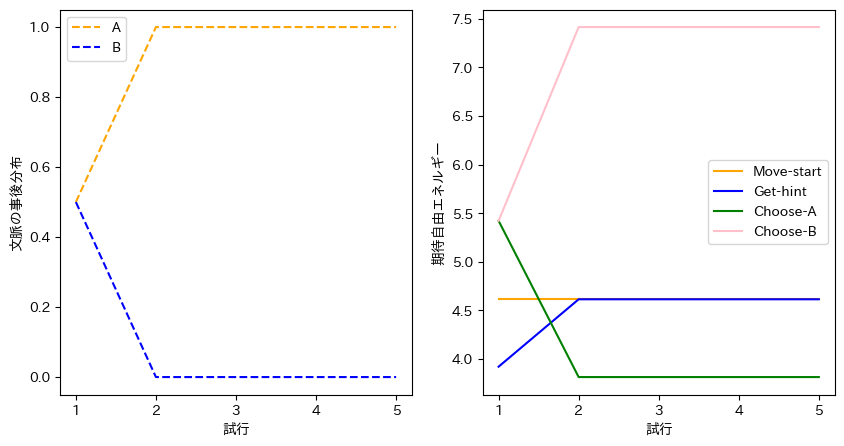

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(range(1,6),qs_save[:,0], color='orange', linestyle='--',label='A')
axes[0].plot(range(1,6),qs_save[:,1], color='blue', linestyle='--',label='B')
axes[0].legend()
axes[0].set_xlabel('試行')
axes[0].set_ylabel('文脈の事後分布')
axes[1].plot(range(1,6),-1*efe_save[:,0], color='orange', linestyle='-',label='Move-start')
axes[1].plot(range(1,6),-1*efe_save[:,1], color='blue', linestyle='-',label='Get-hint')
axes[1].plot(range(1,6),-1*efe_save[:,2], color='green', linestyle='-',label='Choose-A')
axes[1].plot(range(1,6),-1*efe_save[:,3], color='pink', linestyle='-',label='Choose-B')
axes[1].legend()
axes[1].set_xlabel('試行')
axes[1].set_ylabel('期待自由エネルギー')

期待自由エネルギーだけピックアップ

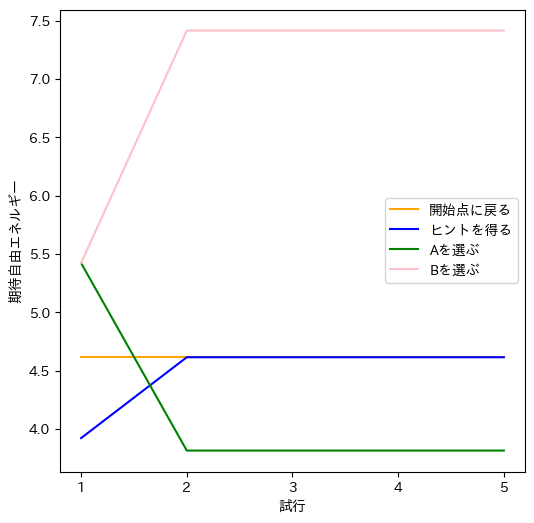

In [49]:
plt.figure(figsize=(6, 6))
plt.plot(range(1,6),-1*efe_save[:,0], color='orange', linestyle='-',label='開始点に戻る')
plt.plot(range(1,6),-1*efe_save[:,1], color='blue', linestyle='-',label='ヒントを得る')
plt.plot(range(1,6),-1*efe_save[:,2], color='green', linestyle='-',label='Aを選ぶ')
plt.plot(range(1,6),-1*efe_save[:,3], color='pink', linestyle='-',label='Bを選ぶ')
plt.xticks(range(1, 6))
plt.xlabel('試行')
plt.ylabel('期待自由エネルギー')
plt.legend()